In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [3]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "~/Downloads/hymenoptera_data/hymenoptera_data"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cpu")

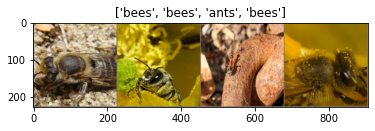

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
inputs.size()

torch.Size([4, 3, 224, 224])

In [8]:
inputs[0].size()

torch.Size([3, 224, 224])

In [11]:
inputs[0][0].size()

tensor([[ 1.4098,  1.4098,  1.4440,  ...,  1.8722,  1.7352,  1.6838],
        [ 1.1358,  1.1187,  1.0673,  ...,  1.9407,  1.8037,  1.7009],
        [ 0.9132,  0.7591,  0.6049,  ...,  1.8893,  1.7009,  1.5982],
        ...,
        [ 0.8961, -0.0116, -0.4054,  ...,  1.8379,  1.5468,  1.4612],
        [ 0.9817,  0.8789, -0.6623,  ...,  1.9407,  2.0263,  2.0263],
        [ 1.1529,  1.4098,  0.8789,  ...,  1.9578,  2.0263,  1.9749]])

In [19]:
characters = "abcdefghijklmnopqrstuvwxyz"
characters_list = [c for c in characters]
length = len(characters_list)
chunks = 8

import math

split_size = math.ceil(length / chunks)

[
    characters_list[max(0, i * split_size) : min(length, (i + 1) * split_size)]
    for i in range(chunks)
]

[['a', 'b', 'c', 'd'],
 ['e', 'f', 'g', 'h'],
 ['i', 'j', 'k', 'l'],
 ['m', 'n', 'o', 'p'],
 ['q', 'r', 's', 't'],
 ['u', 'v', 'w', 'x'],
 ['y', 'z'],
 []]

In [3]:
torch.cuda.is_available()

True

In [5]:
import torch

x = torch.rand(5, 3)
print(x)

tensor([[0.0167, 0.5539, 0.8558],
        [0.7501, 0.8024, 0.4338],
        [0.7656, 0.2974, 0.0164],
        [0.4538, 0.3245, 0.3248],
        [0.8407, 0.1009, 0.4712]])


In [6]:
x.cuda()

C:\Users\yagne\anaconda3\envs\grandstanding\lib\site-packages\torch\cuda\__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3060 Ti with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [2]:
torch.version.cuda

'10.2'

In [3]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']

YIN Algorithm

Input: $x_{t}$ - Discrete Signal (soundwave)

1. Autocorrelation Function of lag $\tau$ at time $t$: $$r_t(\tau) = \sum^{t + W}_{j = t + 1}x_jx_{j+\tau}$$
2. Difference function to identify periodicity: $$d_t(\tau) = \sum^{W}_{j = 1}(x_j-x_{j+\tau})^2 = r_t(0) + r_{t + \tau}(0) - 2r_t(\tau)$$
3. Cumulative Mean Normalized Difference Function to account for "too high" errors, avoid the zero-lag dip, and normalize output:
$$d'_t(\tau) = 
\begin{cases} 
      1 &  \tau = 0 \\
      \frac{d_t(\tau)}{(1/\tau)\sum^{\tau}_{j=1}d_j(\tau)} & otherwise
   \end{cases}
$$
4. Pass through a threshold in order to avoid octave errors and choose smallest $\tau$ that has $d'_t(\tau) < threshold$ or choose global minimum if no suitable $\tau$ found.

5. Parabolic Interpolation by fitting each local minimum of $d'_t(\tau)$ and its immediate neighbors to a parabola to address sampling period inconsistencies. 

6. Local Estimate through median smoothing of $d'_t(\tau)$ for each time t

In [40]:
import numpy as np
import pandas as pd
import librosa
import math

from IPython.display import Audio
import librosa.display
import os.path as osp
import librosa.util as util
import librosa.sequence as sequence
import scipy

import matplotlib.pyplot as plt

In [10]:
min_words = 40
wavs_dir = "C:/Users/yagne/Downloads/mp3s/"
target_sr = 16000
transcripts_path = "../outputs/all_transcripts_v2.csv"
transcripts = pd.read_csv(transcripts_path)


def play_audio(signal, rate):
    return Audio(data=signal, rate=rate)

In [11]:
data = (
    transcripts.loc[
        (transcripts["word_count"] >= min_words)
        & (transcripts["speaker_role"] == "scotus_justice")
    ]
    .copy()
    .reset_index(drop=True)
)

In [13]:
sample_1 = dict(data.iloc[827])

wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.mp3"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.mp3")),
)
print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Anthony_M_Kennedy
File - Line 12-315 - 21
Duration: 11.308
Text: What -- what position -- although they'll tell us in a minute -- does Respondent take on that issue that a determination by the jury suffices? As you understand their brief. They can talk for themselves in a few minutes.


In [244]:
fmin = librosa.note_to_hz("C2")
fmax = librosa.note_to_hz("C7")
y, sr = librosa.load(librosa.ex("trumpet"))
frame_length = 2048
win_length = None
hop_length = None
n_thresholds = 100
beta_parameters = (2, 18)
boltzmann_parameter = 2
resolution = 0.1
max_transition_rate = 35.92
switch_prob = 0.0
no_trough_prob = 0.01
fill_na = np.nan
center = True
pad_mode = "reflect"

In [245]:
if fmin is None or fmax is None:
    raise ParameterError('both "fmin" and "fmax" must be provided')

# Set the default window length if it is not already specified.
if win_length is None:
    win_length = frame_length // 2

if win_length >= frame_length:
    raise ParameterError(
        "win_length={} cannot exceed given frame_length={}".format(
            win_length, frame_length
        )
    )

# Set the default hop if it is not already specified.
if hop_length is None:
    hop_length = frame_length // 4

# Check that audio is valid.
util.valid_audio(y, mono=True)

# Pad the time series so that frames are centered
if center:
    y = np.pad(y, frame_length // 2, mode=pad_mode)

# Frame audio.
y_frames = util.frame(y, frame_length=frame_length, hop_length=hop_length)

# Calculate minimum and maximum periods
min_period = max(int(np.floor(sr / fmax)), 1)
max_period = min(int(np.ceil(sr / fmin)), frame_length - win_length - 1)

# Calculate cumulative mean normalized difference function.
yin_frames = _cumulative_mean_normalized_difference(
    y_frames, frame_length, win_length, min_period, max_period
)

# Parabolic interpolation.
parabolic_shifts = _parabolic_interpolation(yin_frames)

# Find Yin candidates and probabilities.
# The implementation here follows the official pYIN software which
# differs from the method described in the paper.
# 1. Define the prior over the thresholds.
thresholds = np.linspace(0, 1, n_thresholds + 1)
beta_cdf = scipy.stats.beta.cdf(thresholds, beta_parameters[0], beta_parameters[1])
beta_probs = np.diff(beta_cdf)

yin_probs = np.zeros_like(yin_frames)
for i, yin_frame in enumerate(yin_frames.T):
    # 2. For each frame find the troughs.
    is_trough = util.localmin(yin_frame, axis=0)
    is_trough[0] = yin_frame[0] < yin_frame[1]
    (trough_index,) = np.nonzero(is_trough)

    if len(trough_index) == 0:
        continue

    # 3. Find the troughs below each threshold.
    trough_heights = yin_frame[trough_index]
    trough_thresholds = trough_heights[:, None] < thresholds[None, 1:]

    # 4. Define the prior over the troughs.
    # Smaller periods are weighted more.
    trough_positions = np.cumsum(trough_thresholds, axis=0) - 1
    n_troughs = np.count_nonzero(trough_thresholds, axis=0)
    trough_prior = scipy.stats.boltzmann.pmf(
        trough_positions, boltzmann_parameter, n_troughs
    )
    trough_prior[~trough_thresholds] = 0

    # 5. For each threshold add probability to global minimum if no trough is below threshold,
    # else add probability to each trough below threshold biased by prior.
    probs = np.sum(trough_prior * beta_probs, axis=1)
    global_min = np.argmin(trough_heights)
    n_thresholds_below_min = np.count_nonzero(~trough_thresholds[global_min, :])
    probs[global_min] += no_trough_prob * np.sum(beta_probs[:n_thresholds_below_min])

    yin_probs[trough_index, i] = probs

yin_period, frame_index = np.nonzero(yin_probs)

# Refine peak by parabolic interpolation.
period_candidates = min_period + yin_period
period_candidates = period_candidates + parabolic_shifts[yin_period, frame_index]
f0_candidates = sr / period_candidates

n_bins_per_semitone = int(np.ceil(1.0 / resolution))
n_pitch_bins = int(np.floor(12 * n_bins_per_semitone * np.log2(fmax / fmin))) + 1

# Construct transition matrix.
max_semitones_per_frame = round(max_transition_rate * 12 * hop_length / sr)
transition_width = max_semitones_per_frame * n_bins_per_semitone + 1
# Construct the within voicing transition probabilities
transition = sequence.transition_local(
    n_pitch_bins, transition_width, window="triangle", wrap=False
)
# Include across voicing transition probabilities
transition = np.block(
    [
        [(1 - switch_prob) * transition, switch_prob * transition],
        [switch_prob * transition, (1 - switch_prob) * transition],
    ]
)

# Find pitch bin corresponding to each f0 candidate.
bin_index = 12 * n_bins_per_semitone * np.log2(f0_candidates / fmin)
bin_index = np.clip(np.round(bin_index), 0, n_pitch_bins).astype(int)

# Observation probabilities.
observation_probs = np.zeros((2 * n_pitch_bins, yin_frames.shape[1]))
observation_probs[bin_index, frame_index] = yin_probs[yin_period, frame_index]
voiced_prob = np.clip(np.sum(observation_probs[:n_pitch_bins, :], axis=0), 0, 1)
observation_probs[n_pitch_bins:, :] = (1 - voiced_prob[None, :]) / n_pitch_bins

p_init = np.zeros(2 * n_pitch_bins)
p_init[n_pitch_bins:] = 1 / n_pitch_bins

# Viterbi decoding.
states = sequence.viterbi(observation_probs, transition, p_init=p_init)

# Find f0 corresponding to each decoded pitch bin.
freqs = fmin * 2 ** (np.arange(n_pitch_bins) / (12 * n_bins_per_semitone))
f0 = freqs[states % n_pitch_bins]
voiced_flag = states < n_pitch_bins
if fill_na is not None:
    f0[~voiced_flag] = fill_na

In [246]:
clip.shape[0] / 512

486.998046875

In [247]:
yin_frames.shape

(329, 230)

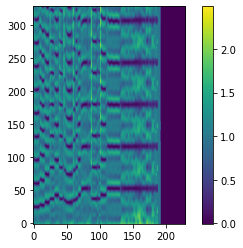

In [248]:
plt.imshow(yin_frames, origin="lower")
plt.colorbar()
plt.show()

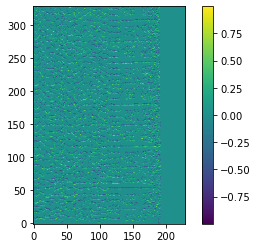

In [249]:
plt.imshow(parabolic_shifts, origin="lower")
plt.colorbar()
plt.show()

(329, 230)

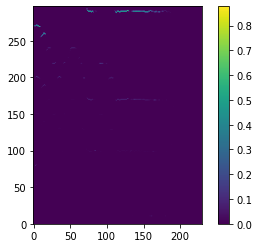

In [156]:
plt.imshow(observation_probs, origin="lower")
plt.ylim(0, 297)
plt.colorbar()
plt.show()

In [151]:
y = clip
fmin = librosa.note_to_hz("C2")
fmax = librosa.note_to_hz("C5")
sr = wav_sr
y, sr = librosa.load(librosa.ex("trumpet"))
frame_length = 2048
win_length = None
hop_length = None
trough_threshold = 0.1
center = True
pad_mode = "reflect"

In [152]:
if fmin is None or fmax is None:
    raise ParameterError('both "fmin" and "fmax" must be provided')

# Set the default window length if it is not already specified.
if win_length is None:
    win_length = frame_length // 2

if win_length >= frame_length:
    raise ParameterError(
        "win_length={} cannot exceed given frame_length={}".format(
            win_length, frame_length
        )
    )

# Set the default hop if it is not already specified.
if hop_length is None:
    hop_length = frame_length // 4

# Check that audio is valid.
util.valid_audio(y, mono=True)

# Pad the time series so that frames are centered
if center:
    y = np.pad(y, frame_length // 2, mode=pad_mode)

# Frame audio.
y_frames = util.frame(y, frame_length=frame_length, hop_length=hop_length)

# Calculate minimum and maximum periods
min_period = max(int(np.floor(sr / fmax)), 1)
max_period = min(int(np.ceil(sr / fmin)), frame_length - win_length - 1)

# Calculate cumulative mean normalized difference function.
yin_frames = _cumulative_mean_normalized_difference(
    y_frames, frame_length, win_length, min_period, max_period
)

# Parabolic interpolation.
parabolic_shifts = _parabolic_interpolation(yin_frames)

# Find local minima.
is_trough = util.localmin(yin_frames, axis=0)
is_trough[0, :] = yin_frames[0, :] < yin_frames[1, :]

# Find minima below peak threshold.
is_threshold_trough = np.logical_and(is_trough, yin_frames < trough_threshold)

# Absolute threshold.
# "The solution we propose is to set an absolute threshold and choose the
# smallest value of tau that gives a minimum of d' deeper than
# this threshold. If none is found, the global minimum is chosen instead."
global_min = np.argmin(yin_frames, axis=0)
yin_period = np.argmax(is_threshold_trough, axis=0)
no_trough_below_threshold = np.all(~is_threshold_trough, axis=0)
yin_period[no_trough_below_threshold] = global_min[no_trough_below_threshold]

# Refine peak by parabolic interpolation.
yin_period = (
    min_period + yin_period + parabolic_shifts[yin_period, range(yin_frames.shape[1])]
)

# Convert period to fundamental frequency.
f0 = sr / yin_period

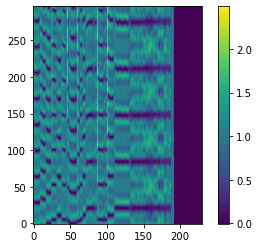

In [153]:
plt.imshow(yin_frames, origin="lower")
plt.colorbar()
plt.show()

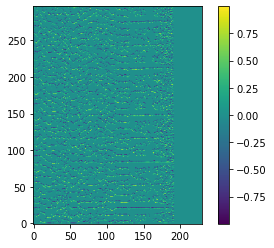

In [154]:
plt.imshow(parabolic_shifts, origin="lower")
plt.colorbar()
plt.show()

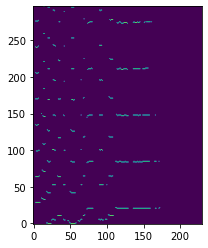

In [155]:
plt.imshow(is_threshold_trough, origin="lower")
plt.show()

In [103]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5"), sr=wav_sr
)
times = librosa.times_like(f0)
yin_f0 = librosa.yin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5"), sr=wav_sr
)

In [102]:
yin_f0

array([ 84.10932848,  84.98615278,  84.44701119,  83.48090266,
        82.42416845, 230.44838819,  77.02203552, 123.06798519,
       101.75813619, 101.12393491,  98.56569019,  97.9074947 ,
       124.41664799, 126.6270004 , 100.35279746,  96.73247454,
       212.24136152, 209.57294133, 199.00733724, 192.16607778,
       209.78955628, 124.00611592, 122.30211772, 121.43818723,
       120.87545145, 121.60250419, 122.31703986, 121.83184218,
       112.09567061, 122.05631587, 122.29969553, 122.70225428,
       124.73484994, 170.5251414 , 152.15561967, 124.5512864 ,
       122.86829981, 123.88253103, 123.8970233 , 123.5832625 ,
       122.41610138, 121.750643  , 123.04288148,  65.23668639,
       120.59516229, 130.69226658, 117.62374446, 114.95130275,
       107.37079272, 103.95070138, 106.72487526, 110.72394021,
       112.93339822, 112.88886852, 111.14310497, 105.57295848,
       101.58580089, 109.71312833, 113.68968851, 367.62942766,
       112.53019965, 105.38306901, 100.63899513, 100.16

In [98]:
is_threshold_trough

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [19]:
def _cumulative_mean_normalized_difference(
    y_frames, frame_length, win_length, min_period, max_period
):
    """Cumulative mean normalized difference function (equation 8 in [#]_)

    .. [#] De Cheveigné, Alain, and Hideki Kawahara.
        "YIN, a fundamental frequency estimator for speech and music."
        The Journal of the Acoustical Society of America 111.4 (2002): 1917-1930.

    Parameters
    ----------
    y_frames : np.ndarray [shape=(frame_length, n_frames)]
        framed audio time series.

    frame_length : int > 0 [scalar]
         length of the frames in samples.

    win_length : int > 0 [scalar]
        length of the window for calculating autocorrelation in samples.

    min_period : int > 0 [scalar]
        minimum period.

    max_period : int > 0 [scalar]
        maximum period.

    Returns
    -------
    yin_frames : np.ndarray [shape=(max_period-min_period+1,n_frames)]
        Cumulative mean normalized difference function for each frame.
    """
    # Autocorrelation.
    a = np.fft.rfft(y_frames, frame_length, axis=0)
    b = np.fft.rfft(y_frames[win_length::-1, :], frame_length, axis=0)
    acf_frames = np.fft.irfft(a * b, frame_length, axis=0)[win_length:]
    acf_frames[np.abs(acf_frames) < 1e-6] = 0

    # Energy terms.
    energy_frames = np.cumsum(y_frames ** 2, axis=0)
    energy_frames = energy_frames[win_length:, :] - energy_frames[:-win_length, :]
    energy_frames[np.abs(energy_frames) < 1e-6] = 0

    # Difference function.
    yin_frames = energy_frames[0, :] + energy_frames - 2 * acf_frames

    # Cumulative mean normalized difference function.
    yin_numerator = yin_frames[min_period : max_period + 1, :]
    tau_range = np.arange(1, max_period + 1)[:, None]
    cumulative_mean = np.cumsum(yin_frames[1 : max_period + 1, :], axis=0) / tau_range
    yin_denominator = cumulative_mean[min_period - 1 : max_period, :]
    yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
    return yin_frames

In [21]:
def _parabolic_interpolation(y_frames):
    """Piecewise parabolic interpolation for yin and pyin.

    Parameters
    ----------
    y_frames : np.ndarray [shape=(frame_length, n_frames)]
        framed audio time series.

    Returns
    -------
    parabolic_shifts : np.ndarray [shape=(frame_length, n_frames)]
        position of the parabola optima
    """
    parabolic_shifts = np.zeros_like(y_frames)
    parabola_a = (y_frames[:-2, :] + y_frames[2:, :] - 2 * y_frames[1:-1, :]) / 2
    parabola_b = (y_frames[2:, :] - y_frames[:-2, :]) / 2
    parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))
    parabolic_shifts[np.abs(parabolic_shifts) > 1] = 0
    return parabolic_shifts

In [117]:
from librosa.feature import melspectrogram
from librosa import core

In [485]:
y = clip
sr = wav_sr
y, sr = librosa.load(librosa.ex("choice"))
S = None
n_fft = 2048
hop_length = 512
lag = 1
max_size = 10
ref = None
detrend = False
center = True
feature = None
aggregate = None
channels = None
kwargs = {}

if aggregate is False:
    raise ParameterError(
        "aggregate={} cannot be False when computing full-spectrum onset strength."
    )

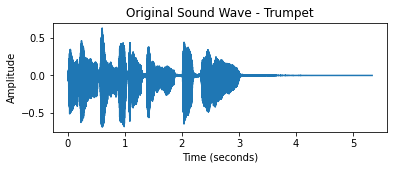

In [483]:
y, sr = librosa.load(librosa.ex("trumpet"))
times = np.arange(len(y)) / sr
plt.figure(figsize=(6, 2))
plt.plot(times, y)
plt.title("Original Sound Wave - Trumpet")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [461]:
fmin = librosa.note_to_hz("C2")
fmax = librosa.note_to_hz("C7")
frame_length = 2048
win_length = None
hop_length = None
trough_threshold = 0.1
center = True
pad_mode = "reflect"

if fmin is None or fmax is None:
    raise ParameterError('both "fmin" and "fmax" must be provided')

# Set the default window length if it is not already specified.
if win_length is None:
    win_length = frame_length // 2

if win_length >= frame_length:
    raise ParameterError(
        "win_length={} cannot exceed given frame_length={}".format(
            win_length, frame_length
        )
    )

# Set the default hop if it is not already specified.
if hop_length is None:
    hop_length = frame_length // 4

# Check that audio is valid.
util.valid_audio(y, mono=True)

# Pad the time series so that frames are centered
if center:
    y = np.pad(y, frame_length // 2, mode=pad_mode)

# Frame audio.
y_frames = util.frame(y, frame_length=frame_length, hop_length=hop_length)

# Calculate minimum and maximum periods
min_period = max(int(np.floor(sr / fmax)), 1)
max_period = min(int(np.ceil(sr / fmin)), frame_length - win_length - 1)

# Calculate cumulative mean normalized difference function.
yin_frames = _cumulative_mean_normalized_difference(
    y_frames, frame_length, win_length, min_period, max_period
)

# Parabolic interpolation.
parabolic_shifts = _parabolic_interpolation(yin_frames)

# Find Yin candidates and probabilities.
# The implementation here follows the official pYIN software which
# differs from the method described in the paper.
# 1. Define the prior over the thresholds.
thresholds = np.linspace(0, 1, n_thresholds + 1)
beta_cdf = scipy.stats.beta.cdf(thresholds, beta_parameters[0], beta_parameters[1])
beta_probs = np.diff(beta_cdf)

yin_probs = np.zeros_like(yin_frames)
for i, yin_frame in enumerate(yin_frames.T):
    # 2. For each frame find the troughs.
    is_trough = util.localmin(yin_frame, axis=0)
    is_trough[0] = yin_frame[0] < yin_frame[1]
    (trough_index,) = np.nonzero(is_trough)

    if len(trough_index) == 0:
        continue

    # 3. Find the troughs below each threshold.
    trough_heights = yin_frame[trough_index]
    trough_thresholds = trough_heights[:, None] < thresholds[None, 1:]

    # 4. Define the prior over the troughs.
    # Smaller periods are weighted more.
    trough_positions = np.cumsum(trough_thresholds, axis=0) - 1
    n_troughs = np.count_nonzero(trough_thresholds, axis=0)
    trough_prior = scipy.stats.boltzmann.pmf(
        trough_positions, boltzmann_parameter, n_troughs
    )
    trough_prior[~trough_thresholds] = 0

    # 5. For each threshold add probability to global minimum if no trough is below threshold,
    # else add probability to each trough below threshold biased by prior.
    probs = np.sum(trough_prior * beta_probs, axis=1)
    global_min = np.argmin(trough_heights)
    n_thresholds_below_min = np.count_nonzero(~trough_thresholds[global_min, :])
    probs[global_min] += no_trough_prob * np.sum(beta_probs[:n_thresholds_below_min])

    yin_probs[trough_index, i] = probs

yin_period, frame_index = np.nonzero(yin_probs)

# Refine peak by parabolic interpolation.
period_candidates = min_period + yin_period
period_candidates = period_candidates + parabolic_shifts[yin_period, frame_index]
f0_candidates = sr / period_candidates

n_bins_per_semitone = int(np.ceil(1.0 / resolution))
n_pitch_bins = int(np.floor(12 * n_bins_per_semitone * np.log2(fmax / fmin))) + 1

# Construct transition matrix.
max_semitones_per_frame = round(max_transition_rate * 12 * hop_length / sr)
transition_width = max_semitones_per_frame * n_bins_per_semitone + 1
# Construct the within voicing transition probabilities
transition = sequence.transition_local(
    n_pitch_bins, transition_width, window="triangle", wrap=False
)
# Include across voicing transition probabilities
transition = np.block(
    [
        [(1 - switch_prob) * transition, switch_prob * transition],
        [switch_prob * transition, (1 - switch_prob) * transition],
    ]
)

# Find pitch bin corresponding to each f0 candidate.
bin_index = 12 * n_bins_per_semitone * np.log2(f0_candidates / fmin)
bin_index = np.clip(np.round(bin_index), 0, n_pitch_bins).astype(int)

# Observation probabilities.
observation_probs = np.zeros((2 * n_pitch_bins, yin_frames.shape[1]))
observation_probs[bin_index, frame_index] = yin_probs[yin_period, frame_index]
voiced_prob = np.clip(np.sum(observation_probs[:n_pitch_bins, :], axis=0), 0, 1)
observation_probs[n_pitch_bins:, :] = (1 - voiced_prob[None, :]) / n_pitch_bins

p_init = np.zeros(2 * n_pitch_bins)
p_init[n_pitch_bins:] = 1 / n_pitch_bins

# Viterbi decoding.
states = sequence.viterbi(observation_probs, transition, p_init=p_init)

# Find f0 corresponding to each decoded pitch bin.
freqs = fmin * 2 ** (np.arange(n_pitch_bins) / (12 * n_bins_per_semitone))
f0 = freqs[states % n_pitch_bins]
voiced_flag = states < n_pitch_bins
if fill_na is not None:
    f0[~voiced_flag] = fill_na

In [462]:
a = np.fft.rfft(y_frames, frame_length, axis=0)
b = np.fft.rfft(y_frames[win_length::-1, :], frame_length, axis=0)
acf_frames = np.fft.irfft(a * b, frame_length, axis=0)[win_length:]
acf_frames[np.abs(acf_frames) < 1e-6] = 0

# Energy terms.
energy_frames = np.cumsum(y_frames ** 2, axis=0)
energy_frames = energy_frames[win_length:, :] - energy_frames[:-win_length, :]
energy_frames[np.abs(energy_frames) < 1e-6] = 0

# Difference function.
yin_frames = energy_frames[0, :] + energy_frames - 2 * acf_frames
yin_frames_orig = yin_frames

# Cumulative mean normalized difference function.
yin_numerator = yin_frames[min_period : max_period + 1, :]
tau_range = np.arange(1, max_period + 1)[:, None]
cumulative_mean = np.cumsum(yin_frames[1 : max_period + 1, :], axis=0) / tau_range
yin_denominator = cumulative_mean[min_period - 1 : max_period, :]
yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))

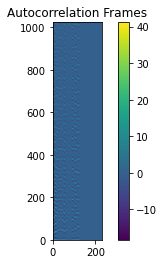

In [463]:
plt.imshow(acf_frames, origin="lower")
plt.title("Autocorrelation Frames")
plt.colorbar()
plt.show()

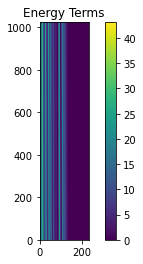

In [464]:
plt.imshow(energy_frames, origin="lower")
plt.title("Energy Terms")
plt.colorbar()
plt.show()

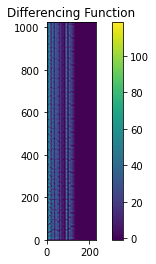

In [465]:
plt.imshow(yin_frames_orig, origin="lower")
plt.title("Differencing Function")
plt.colorbar()
plt.show()

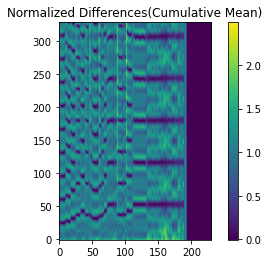

In [466]:
plt.imshow(yin_frames, origin="lower")
plt.colorbar()
plt.title("Normalized Differences(Cumulative Mean)")
plt.show()

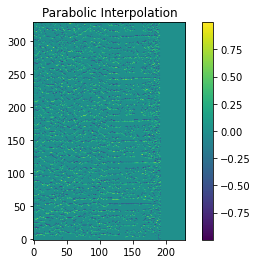

In [467]:
plt.imshow(parabolic_shifts, origin="lower")
plt.colorbar()
plt.title("Parabolic Interpolation")
plt.show()

## DIVERGES HERE

In [468]:
# Find local minima.
is_trough = util.localmin(yin_frames, axis=0)
is_trough[0, :] = yin_frames[0, :] < yin_frames[1, :]

# Find minima below peak threshold.
is_threshold_trough = np.logical_and(is_trough, yin_frames < trough_threshold)

# Absolute threshold.
# "The solution we propose is to set an absolute threshold and choose the
# smallest value of tau that gives a minimum of d' deeper than
# this threshold. If none is found, the global minimum is chosen instead."
global_min = np.argmin(yin_frames, axis=0)
yin_period = np.argmax(is_threshold_trough, axis=0)
no_trough_below_threshold = np.all(~is_threshold_trough, axis=0)
yin_period[no_trough_below_threshold] = global_min[no_trough_below_threshold]
yin_period_before_refinement = yin_period
# Refine peak by parabolic interpolation.
yin_period = (
    min_period + yin_period + parabolic_shifts[yin_period, range(yin_frames.shape[1])]
)

# Convert period to fundamental frequency.
f0 = sr / yin_period

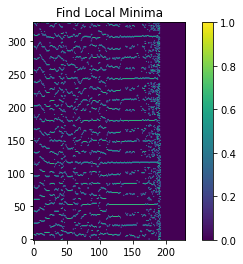

In [469]:
plt.imshow(is_trough, origin="lower")
plt.colorbar()
plt.title("Find Local Minima")
plt.show()

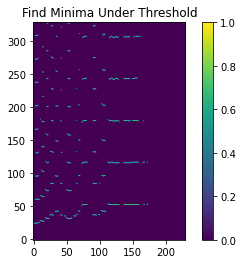

In [470]:
plt.imshow(is_threshold_trough, origin="lower")
plt.colorbar()
plt.title("Find Minima Under Threshold")
plt.show()

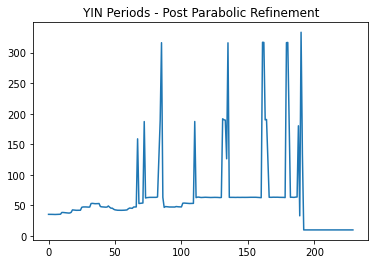

In [471]:
plt.plot(yin_period)
plt.title("YIN Periods - Post Parabolic Refinement")
plt.show()

In [472]:
og_time = librosa.times_like(f0)
print(og_time.shape)

(230,)


Text(0.5, 0, 'Time (seconds)')

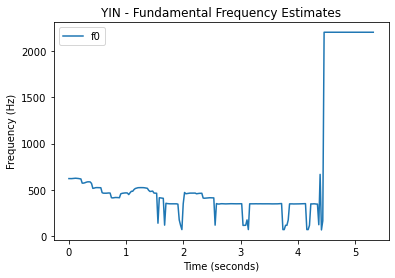

In [473]:
plt.plot(og_time, f0, label="f0")
plt.legend()
plt.title("YIN - Fundamental Frequency Estimates")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")

## PYIN

In [474]:
# Find Yin candidates and probabilities.
# The implementation here follows the official pYIN software which
# differs from the method described in the paper.
# 1. Define the prior over the thresholds.
thresholds = np.linspace(0, 1, n_thresholds + 1)
beta_cdf = scipy.stats.beta.cdf(thresholds, beta_parameters[0], beta_parameters[1])
beta_probs = np.diff(beta_cdf)

yin_probs = np.zeros_like(yin_frames)
for i, yin_frame in enumerate(yin_frames.T):
    # 2. For each frame find the troughs.
    is_trough = util.localmin(yin_frame, axis=0)
    is_trough[0] = yin_frame[0] < yin_frame[1]
    (trough_index,) = np.nonzero(is_trough)

    if len(trough_index) == 0:
        continue

    # 3. Find the troughs below each threshold.
    trough_heights = yin_frame[trough_index]
    trough_thresholds = trough_heights[:, None] < thresholds[None, 1:]

    # 4. Define the prior over the troughs.
    # Smaller periods are weighted more.
    trough_positions = np.cumsum(trough_thresholds, axis=0) - 1
    n_troughs = np.count_nonzero(trough_thresholds, axis=0)
    trough_prior = scipy.stats.boltzmann.pmf(
        trough_positions, boltzmann_parameter, n_troughs
    )
    trough_prior[~trough_thresholds] = 0

    # 5. For each threshold add probability to global minimum if no trough is below threshold,
    # else add probability to each trough below threshold biased by prior.
    probs = np.sum(trough_prior * beta_probs, axis=1)
    global_min = np.argmin(trough_heights)
    n_thresholds_below_min = np.count_nonzero(~trough_thresholds[global_min, :])
    probs[global_min] += no_trough_prob * np.sum(beta_probs[:n_thresholds_below_min])

    yin_probs[trough_index, i] = probs

yin_period, frame_index = np.nonzero(yin_probs)

# Refine peak by parabolic interpolation.
period_candidates = min_period + yin_period
period_candidates = period_candidates + parabolic_shifts[yin_period, frame_index]
f0_candidates = sr / period_candidates

n_bins_per_semitone = int(np.ceil(1.0 / resolution))
n_pitch_bins = int(np.floor(12 * n_bins_per_semitone * np.log2(fmax / fmin))) + 1

# Construct transition matrix.
max_semitones_per_frame = round(max_transition_rate * 12 * hop_length / sr)
transition_width = max_semitones_per_frame * n_bins_per_semitone + 1
# Construct the within voicing transition probabilities
transition = sequence.transition_local(
    n_pitch_bins, transition_width, window="triangle", wrap=False
)
# Include across voicing transition probabilities
transition = np.block(
    [
        [(1 - switch_prob) * transition, switch_prob * transition],
        [switch_prob * transition, (1 - switch_prob) * transition],
    ]
)

# Find pitch bin corresponding to each f0 candidate.
bin_index = 12 * n_bins_per_semitone * np.log2(f0_candidates / fmin)
bin_index = np.clip(np.round(bin_index), 0, n_pitch_bins).astype(int)

# Observation probabilities.
observation_probs = np.zeros((2 * n_pitch_bins, yin_frames.shape[1]))
observation_probs[bin_index, frame_index] = yin_probs[yin_period, frame_index]
voiced_prob = np.clip(np.sum(observation_probs[:n_pitch_bins, :], axis=0), 0, 1)
observation_probs_prevoice = observation_probs
observation_probs[n_pitch_bins:, :] = (1 - voiced_prob[None, :]) / n_pitch_bins

p_init = np.zeros(2 * n_pitch_bins)
p_init[n_pitch_bins:] = 1 / n_pitch_bins

# Viterbi decoding.
states = sequence.viterbi(observation_probs, transition, p_init=p_init)

# Find f0 corresponding to each decoded pitch bin.
freqs = fmin * 2 ** (np.arange(n_pitch_bins) / (12 * n_bins_per_semitone))
f0 = freqs[states % n_pitch_bins]
voiced_flag = states < n_pitch_bins
if fill_na is not None:
    f0[~voiced_flag] = fill_na

In [475]:
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

Text(0, 0.5, 'Probability')

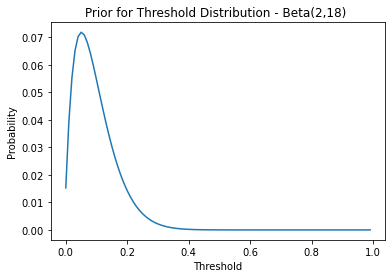

In [476]:
plt.plot(thresholds[:-1], beta_probs)
plt.title("Prior for Threshold Distribution - Beta(2,18) ")
plt.xlabel("Threshold")
plt.ylabel("Probability")

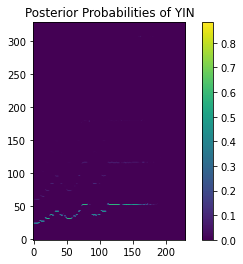

In [477]:
plt.imshow(yin_probs, origin="lower")
plt.colorbar()
plt.title("Posterior Probabilities of YIN")
plt.show()

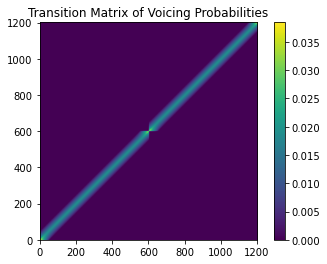

In [478]:
plt.imshow(transition, origin="lower")
plt.colorbar()
plt.title("Transition Matrix of Voicing Probabilities")
plt.show()

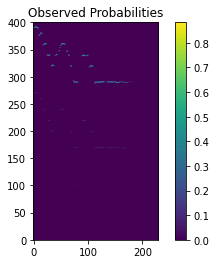

In [479]:
plt.imshow(observation_probs, origin="lower")
plt.colorbar()
plt.ylim(0, 400)
plt.title("Observed Probabilities")
plt.show()

Text(0.5, 1.0, 'Voiced Probabilities')

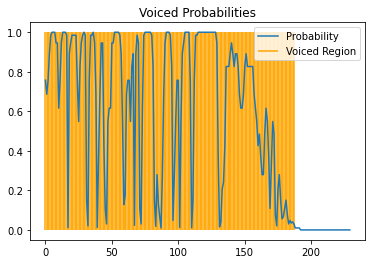

In [480]:
plt.plot(voiced_prob, label="Probability")
plt.vlines(
    np.argwhere(np.where(voiced_flag, 1, 0)).reshape(-1),
    ymin=0,
    ymax=1,
    color="orange",
    label="Voiced Region",
)
plt.legend()
plt.title("Voiced Probabilities")

Text(0.5, 1.0, 'Viterbi Decoding')

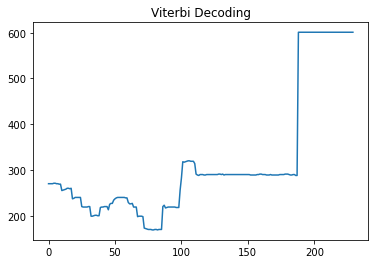

In [481]:
plt.plot(states)
plt.title("Viterbi Decoding")

Text(0.5, 0, 'Time (seconds)')

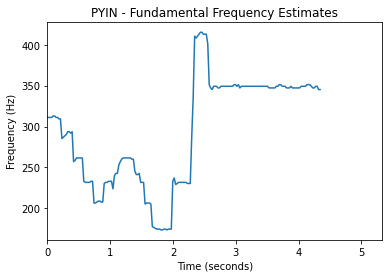

In [482]:
plt.plot(og_time, f0, label="f0")
plt.xlim(0, 5.33)
plt.title("PYIN - Fundamental Frequency Estimates")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")